<a href="https://colab.research.google.com/github/manumeehl/trajectories/blob/main/Trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
''' SYSTEM PACKAGES '''
!apt install tesseract-ocr
!pip install opencv-python-headless pytesseract pytube

In [12]:
''' PYTHON PACKAGES '''
from google.colab.patches import cv2_imshow as show
from pytesseract import image_to_string as img_to_str
from scipy.interpolate import interp1d
from pytube import YouTube, Playlist
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import math
import cv2
import re

In [29]:
''' GENERIC PYTHON UTILITIES '''
def contains_substring(string, list):
  ''' Check if a string contains a substring from a list of strings '''
  for substring in list:
    if substring in string:
      return True
  return False

In [39]:
''' VIDEO UTILITIES '''
def get_video(url):
  ''' Download a Video from YouTube and save it as MP4 '''
  vid = YouTube(url)
  print(f"Downloading Video '{vid.streams[0].title}'")
  vid.streams.filter(progressive=True, file_extension='mp4')\
  .order_by('resolution').desc().first()\
  .download(output_path='temp', filename='launch.mp4')
  print('Download complete')
  vidfile = cv2.VideoCapture('temp/launch.mp4')
  props = {'title': vid.title, 'date': vid.publish_date, 'length': vid.length}
  return vidfile, props

def show_frame(vid, position):
  ''' Show a single frame from a video file '''
  # ToDo: Read the video here
  vid.set(cv2.CAP_PROP_POS_FRAMES, int(position))
  ret, frame = vid.read()
  show(frame)

In [17]:
''' TIME CONVERSION TOOLS '''
def clock_to_secs(clockstring):
  ''' Convert a mission clock string to an integer second value '''
  tense = -1 if clockstring[:2] == 't-' else 1
  # Remove the T+- sign
  clockstring = clockstring [2:]
  # Get the seconds
  units = clockstring.split(':')
  hours = int(units[0])
  minutes = int(units[1])
  seconds = int(units[2])

  return tense * (hours * 3600 + minutes * 60 + seconds)

def elapsed_secs(frame1, frame2, fps):
  ''' Get the time between two frames in a video '''
  return round((frame2 - frame1) / fps, 2)

In [18]:
''' OCR PARSING AND DATA EXTRACTION '''
def parse_clock(string):
  ''' Extract mission clock, altitude and velocity from a given string '''
  mission_clock = re.findall(r't[+-]\d{2}:\d{2}:\d{2}', string.lower().replace(' ', ''))
  if mission_clock: return mission_clock[0]
  else: return None

def parse_trajectory(string):
  ''' Extract altitude and velocity from a given string '''
  # Apply a blacklist
  blacklist = ['stage 1', 'stage 2', 'falcon 9', 'starlink']
  for w in blacklist:
    string = string.replace(w, '')
  # Find all numbers and floats in the string
  numbers = re.findall(r'\d+(?:\.\d+)?', string.lower())
  numbers = list(set([float(x) for x in numbers]))
  # Check if there are exactly two numbers
  if len(numbers) == 2:
   return  [min(numbers), max(numbers)]
  else:
    return None

def extract_data(vid, scope=[]):
  ''' Collect all datapoints from a frame '''
  ret, frame = vid.read()
  # Get the regions of interest
  clockframe, stage1, stage2 = get_snippets(frame)
  ocr_config = '--psm 11'
  # Scan for data
  clock = parse_clock(img_to_str(clockframe, config={}))

  trj_s1, trj_s2 = [], []

  if 's1' in scope:
    trj_s1 = parse_trajectory(img_to_str(stage1, config=ocr_config))
  if 's2' in scope:
    trj_s2 = parse_trajectory(img_to_str(stage2, config=ocr_config))

  return clock, trj_s1, trj_s2

In [19]:
''' VIDEO PROCESSING '''
def preprocess(frame):
  ''' Apply preprocessing filters to a frame '''
  return cv2.bitwise_not(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

def get_snippets(frame):
  ''' Cut out regions of interest and apply filters for OCR '''
  height, width, _ = frame.shape

  stage1 = preprocess(frame[height-80:height-40,50:300])
  stage2 = preprocess(frame[height-80:height-40,width-300:width-50])
  clock = preprocess(frame[height-110:height-20,int(width/2-100):int(width/2+100)])

  return clock, stage1, stage2

In [20]:
''' VIDEO PARAMETER SCAN '''
def await_liftoff(vid):
  ''' Identify the frame at which liftoff occurs '''
  # Look for the clock every minute
  framepos, interval = 0, int(30 * vid.get(cv2.CAP_PROP_FPS))
  first_clock = None
  # Await first mission clock appearance
  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval
    clock, t1, t2 = extract_data(vid)

    # Wait until the mission clock first appears
    if clock and not first_clock:
      first_clock = clock
      interval = 1

    # Now wait for the next full second
    if first_clock and clock != first_clock:
      framepos -= clock_to_secs(clock) * vid.get(cv2.CAP_PROP_FPS)
      return framepos


In [21]:
def detect_meco(velocity: pd.Series, window=5) -> bool:
  vel = velocity.values.tolist()
  # Check if the dataset is long enough:
  if len(vel) < window:
    return False
  # Check if the velocity has been declining for x values
  detected_meco = True
  prev_val = vel[len(vel)-1]
  for i in range(5):
    if vel[len(vel)-1-i] < prev_val:
      detected_meco = False
  return detected_meco

In [55]:
''' CONTINUOUS DATA SCAN '''
waypoints = {
    'MECO' : False
}

def process_launch(vid, liftoff_frame, duration):
  framepos = liftoff_frame
  trajectory = pd.DataFrame(columns = ['clock', 'secs', 's1_alt', 's1_vel', 's2_alt', 's2_vel'])

  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    fps = vid.get(cv2.CAP_PROP_FPS)
    ret, frame = vid.read()

    # If MECO has not happened already, check for it and only look for Stage 1 telemetry
    if not waypoints['MECO']:
        waypoints['MECO'] = detect_meco(trajectory['s1_vel'], window=3)
        # Monitor Stage 1 telemetry only
        clock, trj_s1, trj_s2 = extract_data(vid, ['s1'])
    else:
      # Else, try to monitor both stages
      clock, trj_s1, trj_s2 = extract_data(vid, ['s1', 's2'])

    # Check if any trajectory can be stored
    if clock and (trj_s1 or trj_s2):
      # Modify trajectory for each mission phase, then save it
      # Before MECO if first stage trajectory is available
      if clock and trj_s1 and not trj_s2 and not waypoints['MECO']:
        trj_s2 = trj_s1

      # After MECO if both telemetries are available
      if clock and trj_s1 and trj_s2 and waypoints['MECO']:
        pass

      # After MECO if only second Stage trajectory is available
      if clock and not trj_s1 and trj_s2 and waypoints['MECO']:
        trj_s1 = [0, 0]

      trajectory.loc[len(trajectory)] = [clock, clock_to_secs(clock)] + trj_s1 + trj_s2

    else:
      # Skip a few frames forward for better chances of successfull OCR
      framepos += 5

    # TEMPORARY: Limit scope of trajectory scan
    if framepos > liftoff_frame + (duration*fps):
      break

    # Skip to next second
    framepos += int(fps - ((framepos - liftoff_frame) % fps)) + 3

  return trajectory

Download complete
Processing video Space Development Agency’s Second Tranche 0 Mission from 2023-09-02 00:00:00 and length of 1455
Searching liftoff frame...


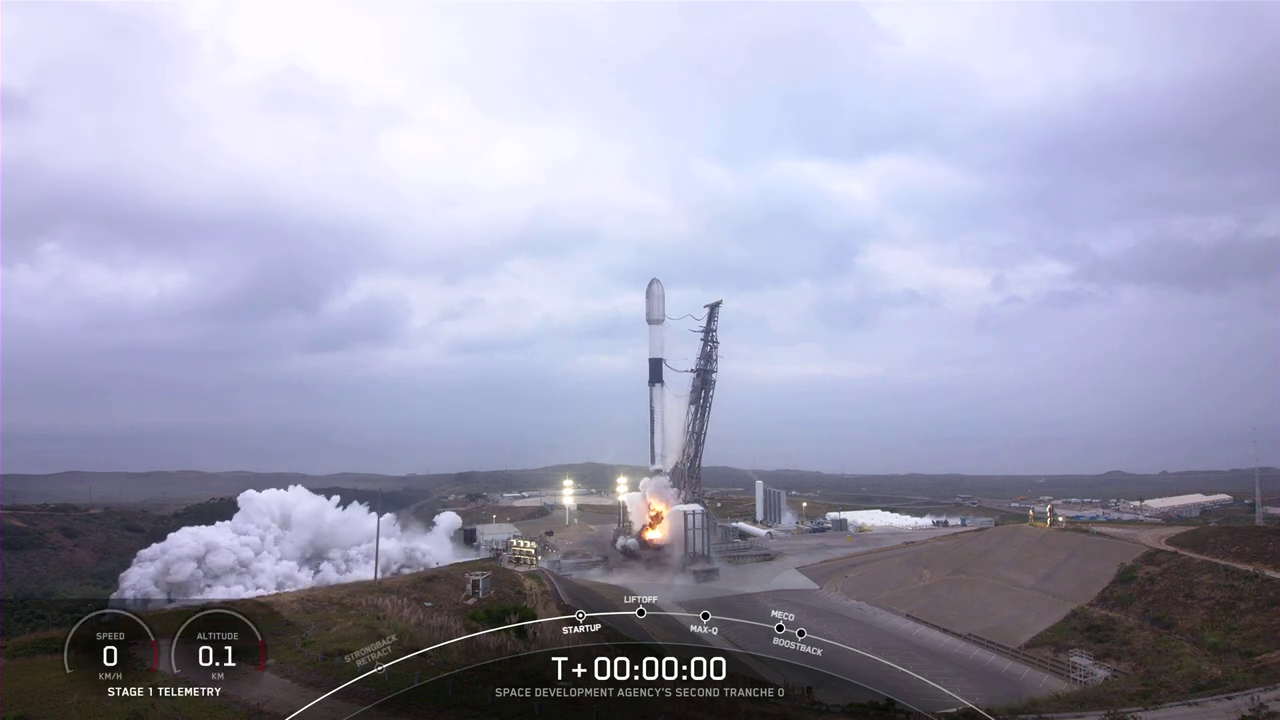

Liftoff registered, now monitoring trajectories...


In [56]:
''' MAIN ROUTINE '''
# Get YouTube Videos
def get_videos_of_playlist(playlist_url):
  return Playlist(playlist_url).video_urls

playlist_url = 'https://www.youtube.com/playlist?list=PLBQ5P5txVQr8qmgRWbVyqhhRzb3Xprefy'
playlist = get_videos_of_playlist(playlist_url)
vidpath = 'temp/launch.mp4'

# Filter out videos which are not launches
blacklist = ['docking', 'undocking']

for url in playlist[:2]:
  # Analyze the current video
  title = YouTube(url).title

  # Skip non-launch videos
  if contains_substring(title.lower(), blacklist):
    continue

  vid, props = get_video(url)
  print(f"Processing video {props['title']} from {props['date']} and length of {props['length']}")

  print('Searching liftoff frame...')
  liftoff_frame = await_liftoff(vid)

  # Skip forward two minutes
  #start_frame = liftoff_frame + 150 * fps

  print('Liftoff registered, now monitoring trajectories...')
  trajectory = process_launch(vid, liftoff_frame, 1 * 60)

  data = {
      'title': props['title'],
      'trajectory': trajectory.to_dict()
  }

  with open(f"launches/{props['date']}", 'w') as json_file:
    json.dump(data, json_file)

In [57]:
''' DATA POST-PROCESSING '''
def remove_spikes(data):
    pos_peaks, _ = find_peaks(data)
    neg_peaks, _ = find_peaks(-np.array(data))
    for peak_index in [*pos_peaks, *neg_peaks]:
        data[peak_index] = data[peak_index - 1]
    return data

def interpolate_curve(x, y):
    x_floor = np.floor(x)
    x_smooth = np.linspace(x_floor[0], x_floor[-1], len(x_floor))

    f = interp1d(x_floor, y, kind='quadratic')
    y_smooth = f(x_smooth)

    return x_smooth, y_smooth

# Create a working copy for data plots
trj = trajectory.copy()

# Process data
for i in ['s1_alt', 's1_vel', 's2_alt', 's2_vel']:
  trj[i] = remove_spikes(trj[i].values.tolist())
  trj[i] = interpolate_curve(trj['secs'].values.tolist(), trj[i])[1]

trj.rename(columns={'s1_alt': 'S1 Altitude',
                    's1_vel': 'S1 Velocity',
                    's2_alt': 'S2 Altitude',
                    's2_vel': 'S2 Velocity'},
           inplace=True)

trj.to_csv('trajectory_corrected.csv')

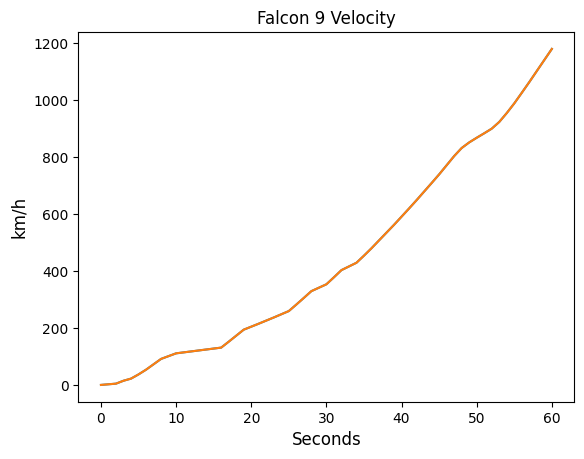

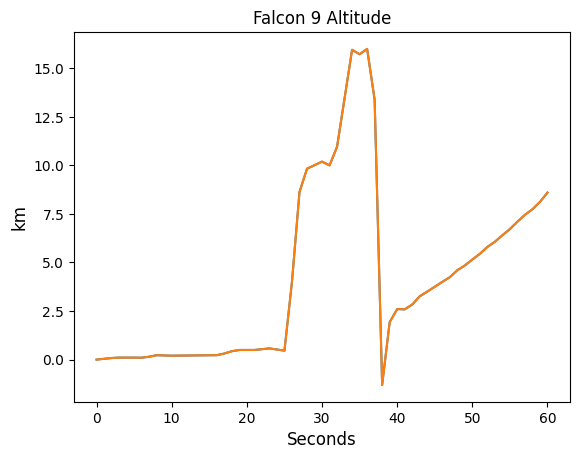

In [58]:
''' DATA PLOTS '''
#trajectory = pd.read_csv('trajectory.csv')
clock = trj['secs'].values.tolist()

s1_alt = trj['S1 Altitude'].values.tolist()
s1_vel = trj['S1 Velocity'].values.tolist()
s2_alt = trj['S2 Altitude'].values.tolist()
s2_vel = trj['S2 Velocity'].values.tolist()

plt.title('Falcon 9 Velocity')
plt.xlabel('Seconds', fontsize=12)
plt.ylabel('km/h', fontsize=12)
plt.plot(clock, s2_vel)
plt.plot(clock, s1_vel)
plt.show()

plt.title('Falcon 9 Altitude')
plt.xlabel('Seconds', fontsize=12)
plt.ylabel('km', fontsize=12)
plt.plot(clock, s2_alt)
plt.plot(clock, s1_alt)
plt.show()